In [0]:
from numpy import array
from pickle import dump
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [5]:
from keras import backend as K
#GPU utilize monitor
print(K.tensorflow_backend._get_available_gpus())

['/job:localhost/replica:0/task:0/device:GPU:0']


In [0]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

In [16]:
# load document
in_filename = '/Google_drive/My Drive/Auto-complete/train_set.txt'
doc = load_doc(in_filename)
#use first 1000000 lenth for training, make the model undercontrol,Unique Tokens will be 9395
doc = doc[0:1000000]
print(len(doc))
print(doc[:200])

FileNotFoundError: ignored

In [0]:
import string

# turn a doc into clean tokens
def clean_doc(doc):
    tokens = doc.split()
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # make lower case
    tokens = [word.lower() for word in tokens]
    return tokens

In [0]:
# clean document
tokens = clean_doc(doc)
print(tokens[:200])
print('Total Tokens: %d' % len(tokens))
print('Unique Tokens: %d' % len(set(tokens)))

In [0]:
# organize into sequences of tokens
length = 50 + 1
sequences = list()
for i in range(length, len(tokens)):
    # select sequence of tokens
    seq = tokens[i-length:i]
    # convert into a line
    line = ' '.join(seq)
    # store
    sequences.append(line)
print('Total Sequences: %d' % len(sequences))

In [0]:
# save tokens to file, one dialog per line
def save_doc(lines, filename):
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

In [0]:
# save sequences to file
out_filename = 'email_sequences.txt'
save_doc(sequences, out_filename)

In [0]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

In [0]:
# load
in_filename = '/Google_drive/My Drive/Auto-complete/email_sequences.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')

In [0]:
# integer encode sequences of words
tokenizer = Tokenizer(num_words = 12345)
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)
# vocabulary size
vocab_size = len(tokenizer.word_index) + 1

In [0]:
# separate into input and output
sequences = array(sequences)
X, y = sequences[:,:-1], sequences[:,-1]
y = to_categorical(y, num_classes=vocab_size)
seq_length = X.shape[1]

In [10]:
X.shape

(179773, 50)

In [11]:
y.shape

(179773, 9396)

In [0]:
#partial validation data
x_val = X[:20000]
partial_x_train = X[20000:]

y_val = y[:20000]
partial_y_train = y[20000:]

In [13]:
# define model
model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=seq_length))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(100, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 50)            469800    
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 100)           60400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 9396)              948996    
Total params: 1,569,696
Trainable params: 1,569,696
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [23]:
# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit model
history = model.fit(partial_x_train, partial_y_train, 
                    batch_size=128, 
                    epochs=100, 
                    callbacks = callbacks, 
                    validation_data=(x_val, y_val),verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 159773 samples, validate on 20000 samples
Epoch 1/100
159773/159773 [==============================] - 315s 2ms/step - loss: 6.8764 - acc: 0.0513 - val_loss: 6.2932 - val_acc: 0.0865
Epoch 2/100
159773/159773 [==============================] - 310s 2ms/step - loss: 6.3812 - acc: 0.0873 - val_loss: 5.9351 - val_acc: 0.1351
Epoch 3/100
159773/159773 [==============================] - 308s 2ms/step - loss: 6.0072 - acc: 0.1249 - val_loss: 5.6289 - val_acc: 0.1568
Epoch 4/100
159773/159773 [==============================] - 312s 2ms/step - loss: 5.7508 - acc: 0.1424 - val_loss: 5.4540 - val_acc: 0.1665
Epoch 5/100
159773/159773 [==============================] - 306s 2ms/step - loss: 5.5033 - acc: 0.1590 - val_loss: 5.2025 - val_acc: 0.1872
Epoch 6/100
159773/159773 [==============================] - 309s 2ms/step - loss: 5.2187 - acc: 0.1768 - val_loss: 4.9825 - val_acc: 0.1971
Epoch 7/100
159773/159773 [============================

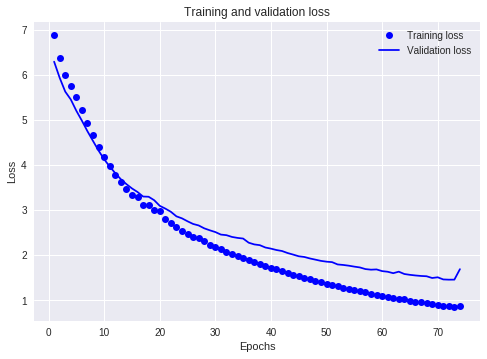

In [24]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [1]:
history_dict = history.history
history_dict.keys()

NameError: ignored

In [25]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

NameError: ignored

<Figure size 576x396 with 0 Axes>

In [0]:
# save the model to file
model.save('model_email.h5')
# save the tokenizer
dump(tokenizer, open('tokenizer.pkl', 'wb'))